In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
# RSUD20Kが今回のコンペのデータの画角に似ているかなと思い採用
!git clone https://github.com/hasibzunair/RSUD20K

Cloning into 'RSUD20K'...
remote: Enumerating objects: 9074, done.
remote: Counting objects: 100% (2969/2969), done.
remote: Compressing objects: 100% (1979/1979), done.
remote: Total 9074 (delta 975), reused 2909 (delta 934), pack-reused 6105 (from 1)
Receiving objects: 100% (9074/9074), 143.55 MiB | 16.97 MiB/s, done.
Resolving deltas: 100% (1073/1073), done.


In [ ]:
# 画像の場所は適宜変更してください.
!tar -xzvf /content/drive/MyDrive/atma18_turing/data/input/images.tar.gz -C ./

In [ ]:
!pip install -q torch==2.1.0 torchvision==0.16.0 torchaudio==2.1.0 --index-url https://download.pytorch.org/whl/cu121

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 GB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 105.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 85.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 24.7 MB/s eta 0:00:00


In [ ]:
!pip install -q wheel
!pip install -q openmim
!mim install -q mmengine
!mim install -q mmcv==2.1.0

In [ ]:
!pip install -e /content/RSUD20K/object_detectors/detr

Obtaining file:///content/RSUD20K/object_detectors/detr
  Preparing metadata (setup.py) ... done
  Attempting uninstall: mmdet
    Found existing installation: mmdet 3.2.0
    Uninstalling mmdet-3.2.0:
      Successfully uninstalled mmdet-3.2.0
  Running setup.py develop for mmdet


In [ ]:
import argparse
import os
import os.path as osp
import warnings
from copy import deepcopy

from mmengine import ConfigDict
from mmengine.config import Config, DictAction
from mmengine.runner import Runner

from mmdet.engine.hooks.utils import trigger_visualization_hook
from mmdet.evaluation import DumpDetResults
from mmdet.registry import RUNNERS
from mmdet.utils import setup_cache_size_limit_of_dynamo

os.chdir("RSUD20K")
config_path = "object_detectors/detr/configs/detr/detr_r50_8xb2-400e_custom_test.py"
cfg = Config.fromfile(config_path)
cfg.launcher = "none"
# cfg.test_evaluator.classwise=True
cfg.load_from = "detr.pth" # github repositoryからダウンロードしてください.
cfg.work_dir = "xxxx" # 適宜設定

runner = Runner.from_cfg(cfg)

# Access the model
model = runner.model

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


11/22 02:18:35 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 86325273
    GPU 0: NVIDIA L4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.2, V12.2.140
    GCC: x86_64-linux-gnu-gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.1.0+cu121
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute_50,code=s

In [ ]:
# 適宜変更してください
input_dir = "xxx"
output_dir = "xxx"
image_dir = "xxx"

In [ ]:
import pandas as pd
df = pd.read_csv(os.path.join(input_dir, "train_features.csv"))
file_ids = df["ID"].values

test_df = pd.read_csv(os.path.join(input_dir, "test_features.csv"))
test_file_ids = test_df["ID"].values

In [ ]:
from joblib import Parallel, delayed
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD
from PIL import Image
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn

model.decoder = nn.Identity()
model.eval().to("cuda")

feats_0 = []
feats_05 = []
feats_1 = []

all_file_ids = np.concatenate([file_ids, test_file_ids])

bs = 128
for i in tqdm(range(0, len(all_file_ids), bs)):
    imgs_0 = []
    imgs_05 = []
    imgs_1 = []
    for file_id in all_file_ids[i:i+bs]:
        scene_id, frame_id = file_id.split("_")
        imgs_0.append(np.array(Image.open(f"/content/images/{scene_id}/{frame_id}/image_t.png")))
        imgs_05.append(np.array(Image.open(f"/content/images/{scene_id}/{frame_id}/image_t-0.5.png")))
        imgs_1.append(np.array(Image.open(f"/content/images/{scene_id}/{frame_id}/image_t-1.0.png")))
    imgs_0 = np.stack(imgs_0, axis=0)
    imgs_05 = np.stack(imgs_05, axis=0)
    imgs_1 = np.stack(imgs_1, axis=0)

    imgs_0 = torch.tensor(imgs_0).float().permute([0, 3, 1, 2]).to("cuda")
    imgs_05 = torch.tensor(imgs_05).float().permute([0, 3, 1, 2]).to("cuda")
    imgs_1 = torch.tensor(imgs_1).float().permute([0, 3, 1, 2]).to("cuda")

    with torch.no_grad():
        feats = model.backbone(torch.cat([imgs_0, imgs_05, imgs_1], dim=0))
    feats = feats[0].detach().cpu().numpy() # (B, 2048, 2, 4)
    feats = feats.reshape(-1, 2048, 8).transpose([0, 2, 1]) # (B, 8, 2048)

    feats_0.append(feats[:len(imgs_0)])
    feats_05.append(feats[len(imgs_0):len(imgs_0)+len(imgs_05)])
    feats_1.append(feats[len(imgs_0)+len(imgs_05):])

feats_0 = np.concatenate(feats_0, axis=0)
feats_05 = np.concatenate(feats_05, axis=0)
feats_1 = np.concatenate(feats_1, axis=0)

100%|██████████| 353/353 [01:53<00:00,  3.11it/s]


In [ ]:
feats_0.shape

(45098, 8, 2048)

In [ ]:
train_feats_0 = feats_0[:len(file_ids)].copy()
train_feats_05 = feats_05[:len(file_ids)].copy()
train_feats_1 = feats_1[:len(file_ids)].copy()

test_feats_0 = feats_0[len(file_ids):].copy()
test_feats_05 = feats_05[len(file_ids):].copy()
test_feats_1 = feats_1[len(file_ids):].copy()

In [ ]:
np.save(os.path.join(output_dir, "train_DETR_backbone_feats_t.npy"), train_feats_0)
np.save(os.path.join(output_dir, "train_DETR_backbone_feats_t-0.5.npy"), train_feats_05)
np.save(os.path.join(output_dir, "train_DETR_backbone_feats_t-1.0.npy"), train_feats_1)

np.save(os.path.join(output_dir, "test_DETR_backbone_feats_t.npy"), test_feats_0)
np.save(os.path.join(output_dir, "test_DETR_backbone_feats_t-0.5.npy"), test_feats_05)
np.save(os.path.join(output_dir, "test_DETR_backbone_feats_t-1.0.npy"), test_feats_1)

In [ ]:
corrs_05_1 = []
corrs_0_05 = []
for i in tqdm(range(len(feats_0))):
    corrs_05_1.append((normalize(feats_05[i], axis=1) * normalize(feats_1[i], axis=1)).sum(axis=1))
    corrs_0_05.append((normalize(feats_0[i], axis=1) * normalize(feats_05[i], axis=1)).sum(axis=1))
corrs_05_1 = np.stack(corrs_05_1, axis=0)
corrs_0_05 = np.stack(corrs_0_05, axis=0)

100%|██████████| 45098/45098 [00:52<00:00, 861.46it/s]


In [ ]:
train_corrs_05_1 = corrs_05_1[:len(file_ids)].copy()
train_corrs_0_05 = corrs_0_05[:len(file_ids)].copy()

test_corrs_05_1 = corrs_05_1[len(file_ids):].copy()
test_corrs_0_05 = corrs_0_05[len(file_ids):].copy()

np.save(os.path.join(output_dir, "train_DETR_backbone_feats_t_t-0.5_corrs.npy"), train_corrs_0_05)
np.save(os.path.join(output_dir, "train_DETR_backbone_feats_t-0.5_t-1.0_corrs.npy"), train_corrs_05_1)

np.save(os.path.join(output_dir, "test_DETR_backbone_feats_t_t-0.5_corrs.npy"), test_corrs_0_05)
np.save(os.path.join(output_dir, "test_DETR_backbone_feats_t-0.5_t-1.0_corrs.npy"), test_corrs_05_1)

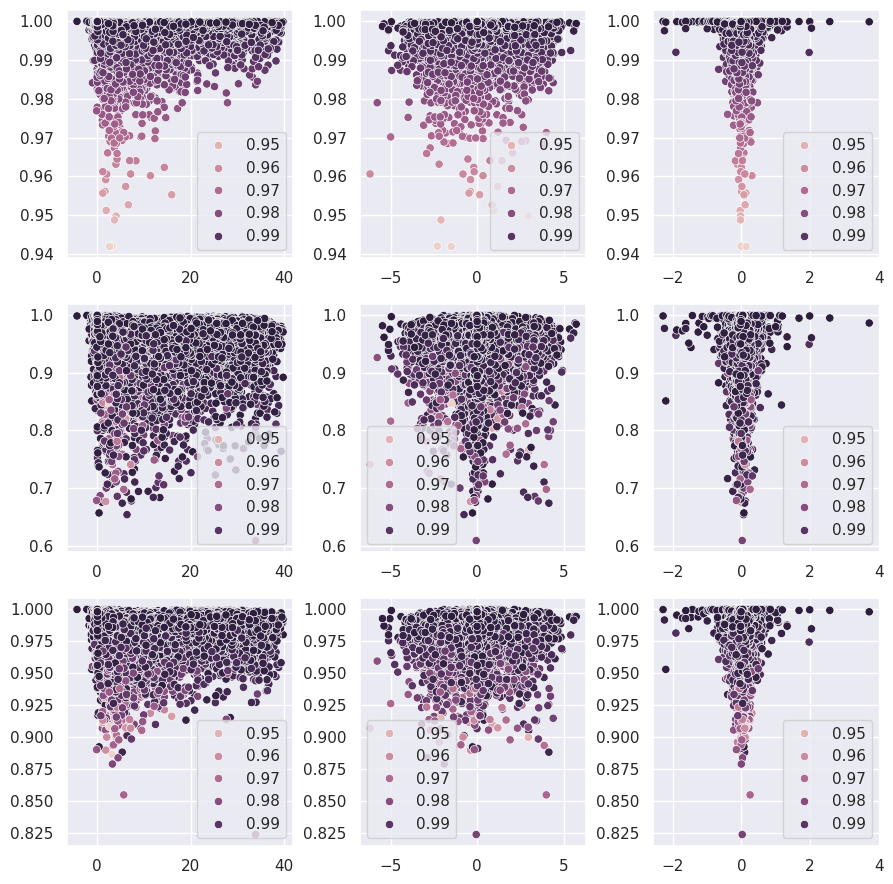

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# x, y, zと関係あるか？
x_mean = df[[f"x_{i}" for i in range(5)]].values.mean(axis=1)
y_mean = df[[f"y_{i}" for i in range(5)]].values.mean(axis=1)
z_mean = df[[f"z_{i}" for i in range(5)]].values.mean(axis=1)

corrs_max = np.concatenate([train_corrs_05_1, train_corrs_0_05], axis=1).max(axis=1)
corrs_min = np.concatenate([train_corrs_05_1, train_corrs_0_05], axis=1).min(axis=1)
corrs_mean = np.concatenate([train_corrs_05_1, train_corrs_0_05], axis=1).mean(axis=1)

fig, axes = plt.subplots(figsize=(9,9), ncols=3, nrows=3)
sns.scatterplot(x=x_mean, y=corrs_max, hue=corrs_max, ax=axes[0,0])
sns.scatterplot(x=y_mean, y=corrs_max, hue=corrs_max, ax=axes[0,1])
sns.scatterplot(x=z_mean, y=corrs_max, hue=corrs_max, ax=axes[0,2])

sns.scatterplot(x=x_mean, y=corrs_min, hue=corrs_max, ax=axes[1,0])
sns.scatterplot(x=y_mean, y=corrs_min, hue=corrs_max, ax=axes[1,1])
sns.scatterplot(x=z_mean, y=corrs_min, hue=corrs_max, ax=axes[1,2])

sns.scatterplot(x=x_mean, y=corrs_mean, hue=corrs_max, ax=axes[2,0])
sns.scatterplot(x=y_mean, y=corrs_mean, hue=corrs_max, ax=axes[2,1])
sns.scatterplot(x=z_mean, y=corrs_mean, hue=corrs_max, ax=axes[2,2])

fig.tight_layout()
plt.show()

In [ ]:
def get_trajectory(row):
    TARGET_COLUMNS = ['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1', 'x_2', 'y_2', 'z_2', 'x_3', 'y_3', 'z_3', 'x_4', 'y_4', 'z_4', 'x_5', 'y_5', 'z_5']

    # データフレームのターゲット情報から可視化可能なtrajectoryに変換
    pivot_df = row[TARGET_COLUMNS].to_frame().reset_index()

    pivot_df.columns = ['coordinate', 'value']

    # 座標軸(x,y,z)と番号(0-5)を正規表現で抽出
    # 例：'x_0' -> axis='x', number='0'
    pivot_df[['axis', 'number']] = pivot_df['coordinate'].str.extract(r'([xyz])_(\d+)')

    # ピボットテーブルを作成：
    # - インデックス：番号(0-5)
    # - カラム：座標軸(x,y,z)
    # - 値：対応する座標値
    trajectory = pivot_df.pivot(index='number', columns='axis', values='value')

    # インデックスを数値型に変換
    trajectory.index = trajectory.index.astype(int)

    # インデックスでソートし、numpy配列に変換
    trajectory = trajectory.sort_index().values
    return trajectory

# Fetch trajectories in advance
train_trajectories = np.stack(Parallel(n_jobs=4)(delayed(get_trajectory)(row) for _, row in tqdm(df.iterrows(), total=len(df), desc="Fetching trajectories....")), axis=0)
train_trajectories = train_trajectories.astype("float")

Fetching trajectories....: 100%|██████████| 43371/43371 [00:38<00:00, 1125.04it/s]


In [ ]:
!pip install -q umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.4 MB/s eta 0:00:00


In [ ]:
from umap import UMAP
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

mean_xyz = train_trajectories.mean(axis=1)

fig, axes = plt.subplots(figsize=(15, 40), ncols=3, nrows=8)

for i in range(8):
    umap_coords = UMAP(n_components=2, random_state=42).fit_transform(train_feats_0[:, i, :])
    sns.scatterplot(x=umap_coords[:, 0], y=umap_coords[:, 1], hue=mean_xyz[:, 0], ax=axes[i, 0])
    sns.scatterplot(x=umap_coords[:, 0], y=umap_coords[:, 1], hue=mean_xyz[:, 1], ax=axes[i, 1])
    sns.scatterplot(x=umap_coords[:, 0], y=umap_coords[:, 1], hue=mean_xyz[:, 2], ax=axes[i, 2])
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plt_idxes = np.argsort(corrs_min)[::-1][:20]

for idx in plt_idxes:
    file_id = file_ids[idx]
    scene_id, frame_id = file_id.split("_")
    print(file_id)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    ax1.set_axis_off()
    ax1.imshow(Image.open(f"/content/images/{scene_id}/{frame_id}/image_t.png"))
    ax2.set_axis_off()
    ax2.imshow(Image.open(f"/content/images/{scene_id}/{frame_id}/image_t-0.5.png"))
    ax3.set_axis_off()
    ax3.imshow(Image.open(f"/content/images/{scene_id}/{frame_id}/image_t-1.0.png"))
    ax1.set_title(f"x: {x_mean[idx]:.3f}")
    ax2.set_title(f"y: {y_mean[idx]:.3f}")
    ax3.set_title(f"z: {z_mean[idx]:.3f}")
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# 3frame間で類似度が低ければ，よく動いている (x, y, zの変化が大きい)かな？

plt_idxes = np.argsort(corrs_max)[:20]

for idx in plt_idxes:
    file_id = file_ids[idx]
    scene_id, frame_id = file_id.split("_")
    print(file_id)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    ax1.set_axis_off()
    ax1.imshow(Image.open(f"/content/images/{scene_id}/{frame_id}/image_t.png"))
    ax2.set_axis_off()
    ax2.imshow(Image.open(f"/content/images/{scene_id}/{frame_id}/image_t-0.5.png"))
    ax3.set_axis_off()
    ax3.imshow(Image.open(f"/content/images/{scene_id}/{frame_id}/image_t-1.0.png"))
    ax1.set_title(f"x: {x_mean[idx]:.3f}")
    ax2.set_title(f"y: {y_mean[idx]:.3f}")
    ax3.set_title(f"z: {z_mean[idx]:.3f}")
    plt.show()

Output hidden; open in https://colab.research.google.com to view.